# Evaluation

## Preliminaries

### Imports

In [1]:
import os

import pickle
import bz2

In [2]:
import pandas as pd

In [3]:
import torch
import torch.nn.functional as F

/home/vincenzo/anaconda3/envs/gstt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [74]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
from mellotron_api import load_tts, load_vocoder, load_arpabet_dict
from mellotron_api import get_gst_embeddings, get_gst_scores
from mellotron_api.api import _synthesise_speech_mellotron

2023-01-15 17:13:45.523572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from gsttransformer.speech_api import ChatSpeechGenerator

In [7]:
from joblib import Parallel
from joblib import delayed
from joblib import parallel_backend

### Constants

In [8]:
RAW_DATA_PATH = '../resources/data/raw'
DATA_PATH = '../resources/data/cache'
OUTPUT_PATH = '../resources/data/eval'

if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

In [9]:
SPLITS = ['train', 'validation', 'test']

In [10]:
OUT_DF_COLUMNS = [
    'Model', 'Params [M]', 'Approach', 'Split', 'Audio file path', 'MSE', 'KL-Divergence', 'Frobenius norm (embeddings)', 'Frobenius norm (combination weights)'
]

In [11]:
MODEL_PATH = '../experiments/DGST/multi_config_final_2023_01_14_18_13_08'

In [12]:
DEVICE = torch.device('cuda')

### Helper functions

In [13]:
def load_data(path):
    with bz2.BZ2File(path, 'rb') as f:
        data = pickle.load(f)

    return data

In [14]:
def store_data(data, path):
    with bz2.BZ2File(path, 'wb') as f:
        pickle.dump(data, f)

In [15]:
def get_tgt_data(path, utterance):
    gst_embedding = get_gst_embeddings(
        os.path.join(RAW_DATA_PATH, path), mellotron, mellotron_stft, mellotron_hparams, device=DEVICE
    ),
    gst_scores = get_gst_scores(
        os.path.join(RAW_DATA_PATH, path), mellotron, mellotron_stft, mellotron_hparams, device=DEVICE
    ),
    mel_spec = _synthesise_speech_mellotron(
        utterance, mellotron, mellotron_stft, mellotron_hparams, arpabet_dict,
        reference_audio_path=os.path.join(RAW_DATA_PATH, path), device=DEVICE
    )[1]
            
    return path, (gst_embedding, gst_scores, mel_spec)

In [16]:
def get_pred_data(path, utterance, context, compute_mel_spec, split):
    gst_embeddings, gst_scores = dgst._predict_gst(utterance, dialogue=context)

    if compute_mel_spec:
        mel_spec_embeds = _synthesise_speech_mellotron(
            utterance, mellotron, mellotron_stft, mellotron_hparams, arpabet_dict,
            reference_audio_path=os.path.join(RAW_DATA_PATH, path),
            gst_style_embedding=gst_embeddings, device=DEVICE
        )[1]
        mel_spec_weights = _synthesise_speech_mellotron(
            utterance, mellotron, mellotron_stft, mellotron_hparams, arpabet_dict,
            reference_audio_path=os.path.join(RAW_DATA_PATH, path),
            gst_head_style_scores=gst_scores, device=DEVICE
        )[1]
    else:
        mel_spec_embeds = mel_spec_weights = None
            
    return path, (gst_embeddings, gst_scores, mel_spec_embeds, mel_spec_weights, split)

In [17]:
def frobenius_norm(m1, m2):
    if m1.size() != m2.size():
        max_len = max( m1.size(-1), m2.size(-1))
        m1 = torch.nn.functional.pad(m1, (0, max_len - m1.size(-1)))
        m2 = torch.nn.functional.pad(m2, (0, max_len - m2.size(-1)))
    return (((m1 - m2) ** 2)).sum() ** 0.5

In [18]:
def compute_scores(path, tgt, pred):
    tgt_gst_embeddings, tgt_gst_scores, tgt_mel_spec = tgt
    gst_embeddings, gst_scores, mel_spec_embeds, mel_spec_weights, split = pred
    
    mse = F.mse_loss(
        torch.tensor(gst_embeddings).unsqueeze(0),torch.tensor(tgt_gst_embeddings), reduction='none'
    ).mean(-1).item()
    kl = F.kl_div(
        torch.tensor(gst_scores).log(), torch.tensor(tgt_gst_scores).log(), reduction='none', log_target=True
    ).sum(-1).mean(1).item()

    if mel_spec_embeds is not None and mel_spec_weights is not None:
        frob_embeds = frobenius_norm(tgt_mel_spec, mel_spec_embeds)
        frob_weights = frobenius_norm(tgt_mel_spec, mel_spec_weights)
    else:
        frob_embeds = frob_weights = None
        
    return split, path, mse, kl, frob_embeds, frob_weights

## Data

In [19]:
data = {
    split: load_data(os.path.join(DATA_PATH, f'dgst_corpus_{split}.pbz2'))
    for split in SPLITS[1:]
}

## Models

In [20]:
mellotron, mellotron_stft, mellotron_hparams = load_tts('../resources/models/mellotron/mellotron_libritts.pt', device=DEVICE)
# tacotron2, tacotron2_stft, tacotron2_hparams = load_tts('resources/tts/tacotron_2/tacotron2_statedict.pt', model='tacotron2')
# waveglow, denoiser = load_vocoder('resources/vocoder/waveglow/waveglow_256channels_universal_v4.pt')
arpabet_dict = load_arpabet_dict('../tts_mellotron_api/mellotron/data/cmu_dictionary')

/home/vincenzo/Documents/gsttransformer/tts_mellotron_api/mellotron/stft.py:67: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
/home/vincenzo/Documents/gsttransformer/tts_mellotron_api/mellotron/layers.py:63: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0.0, fmax=8000.0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


In [32]:
language_models = {
    'DialoGPT (117M)': 'microsoft/DialoGPT-small',
    'DialoGPT (345M)': 'microsoft/DialoGPT-medium',
    'DialoGPT (762M)': 'microsoft/DialoGPT-large',
    'Therapy-DLDLM': '../../dldlm/resources/models/therapy_dldlm'
}

model_size_mapping = {
    'DialoGPT (117M)': 117,
    'DialoGPT (345M)': 345,
    'DialoGPT (762M)': 762,
    'Therapy-DLDLM': 762
}

dgpt_mapping = {
    'lm_small': 'DialoGPT (117M)',
    'lm_medium': 'DialoGPT (345M)',
    'lm_large': 'DialoGPT (762M)'
}

In [22]:
approaches_mapping = {
    'resp': 'Response',
    'resp_from_ctx': 'Response (from context)',
    'ctx_resp': 'Context and response'
}

dgst_models_dict = {
    **{
        (dgpt_mapping[model], approach, language_models[dgpt_mapping[model]]): (
            os.path.join(MODEL_PATH, 'model', f'best_checkpoint_{model}_{approach}', 'dgst.pt'),
            language_models[dgpt_mapping[model]],
            'gpt2',
            {'encoding_mode': approach, 'max_context_len': 256}
        )
        for model in dgpt_mapping for approach in approaches_mapping
    },
    **{
        ('Therapy-DLDLM', approach, approaches_mapping[approach]): (
            os.path.join(MODEL_PATH, 'model', f'best_checkpoint_therapy_lm_large_{approach}', 'dgst.pt'),
            language_models['Therapy-DLDLM'],
            language_models['Therapy-DLDLM'],
            {
                'encoding_mode': approach,
                'prefix_token': '<|prior|>',
                'suffix_token': '<|posterior|>',
                'max_context_len': 256
            }
        )
        for approach in approaches_mapping
    }
}

In [23]:
with torch.no_grad(), parallel_backend('threading', n_jobs=1):
    if os.path.exists(os.path.join(DATA_PATH, f'tgt_eval_data.pbz2')):
        tgt_data = load_data(os.path.join(DATA_PATH, f'tgt_eval_data.pbz2'))
    else:
        tgt_data = dict(Parallel(verbose=0)(
            delayed(get_tgt_data)(sample['audio_file_path'], sample['utterance']) 
            for split, samples in data.items() for sample in samples
        ))
        store_data(tgt_data, os.path.join(DATA_PATH, f'tgt_eval_data.pbz2'))
    

In [54]:
tmp = pred_data['IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M000.wav']
tmp[1].sum(0)

AttributeError: 'list' object has no attribute 'sum'

In [39]:
out_data = []

with torch.no_grad(), parallel_backend('threading', n_jobs=1):
    for (lm_id, approach, dgst_approach), (dgst_path, lm_path, tokeniser_path, kwargs) in dgst_models_dict.items():
        dgst = ChatSpeechGenerator(
            dgst_path, tokeniser_path, lm_path, 
            mellotron=(mellotron, mellotron_stft, mellotron_hparams), 
            **kwargs
        )
        dgst.gpt2.to(dgst.device)
        dgst.gstt.to(dgst.device)
        
        if os.path.exists(os.path.join(DATA_PATH, f'predictions_{approach}_{lm_id}.pbz2')):
            pred_data = load_data(os.path.join(DATA_PATH, f'predictions_{approach}_{lm_id}.pbz2'))
        else:
            pred_data = dict(Parallel(verbose=0)(
                delayed(get_pred_data)(sample['audio_file_path'], sample['utterance'], sample['context'], lm_id == 'Therapy-DLDLM' and approach == 'resp_from_ctx', split)
                for split, samples in data.items() for sample in samples
            ))
            store_data(pred_data, os.path.join(DATA_PATH, f'predictions_{approach}_{lm_id}.pbz2'))
        
        scores = Parallel(verbose=0)(
            delayed(compute_scores)(path, tgt_data[path], preds) for path, preds in pred_data.items()
        )

        out_data += [
            [lm_id, model_size_mapping[lm_id], approach, *score] 
            for score in scores
        ]

Some weights of the model checkpoint at microsoft/DialoGPT-small were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/vincenzo/anaconda3/envs/gstt/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Some weights of the model checkpoint at microsoft/DialoGPT-small were not used when initializ

In [40]:
out_df = pd.DataFrame(out_data, columns=OUT_DF_COLUMNS)
out_df

,Model,Params [M],Approach,Split,Audio file path,MSE,KL-Divergence,Frobenius norm (embeddings),Frobenius norm (combination weights)
0,DialoGPT (117M),117,resp,test,IEMOCAP_full_release/Session1/sentences/wav/Se...,0.068611,0.181041,None,None
1,DialoGPT (117M),117,resp,test,IEMOCAP_full_release/Session1/sentences/wav/Se...,0.122788,0.365659,None,None
2,DialoGPT (117M),117,resp,test,IEMOCAP_full_release/Session1/sentences/wav/Se...,0.111141,0.356507,None,None
3,DialoGPT (117M),117,resp,test,IEMOCAP_full_release/Session1/sentences/wav/Se...,0.113299,0.359836,None,None
4,DialoGPT (117M),117,resp,test,IEMOCAP_full_release/Session1/sentences/wav/Se...,0.112090,0.325865,None,None
...,...,...,...,...,...,...,...,...,...
46039,Therapy-DLDLM,762,ctx_resp,test,IEMOCAP_full_release/Session3/sentences/wav/Se...,0.019812,0.053246,None,None
46040,Therapy-DLDLM,762,ctx_resp,test,IEMOCAP_full_release/Session3/sentences/wav/Se...,0.039018,0.097191,None,None
46041,Therapy-DLDLM,762,ctx_resp,test,IEMOCAP_full_release/Session3/sentences/wav/Se...,0.060281,0.120501,None,None
46042,Therapy-DLDLM,762,ctx_resp,test,IEMOCAP_full_release/Session3/sentences/wav/Se...,0.031350,0.046049,None,None


In [41]:
out_df.to_csv(os.path.join(OUTPUT_PATH, 'results.csv'), index=False)

In [55]:
out_df.groupby(['Split','Model', 'Approach'], sort=False).mean()

/tmp/ipykernel_196576/1044198660.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  out_df.groupby(['Split','Model', 'Approach'], sort=False).mean()


,,,Params [M],MSE,KL-Divergence
Split,Model,Approach,,,
test,DialoGPT (117M),resp,117.0,0.048772,0.130230
validation,DialoGPT (117M),resp,117.0,0.053329,0.145762
test,DialoGPT (117M),resp_from_ctx,117.0,0.057225,0.153909
validation,DialoGPT (117M),resp_from_ctx,117.0,0.062832,0.167533
test,DialoGPT (117M),ctx_resp,117.0,0.060565,0.164199
validation,DialoGPT (117M),ctx_resp,117.0,0.065631,0.176808
test,DialoGPT (345M),resp,345.0,0.042904,0.107730
validation,DialoGPT (345M),resp,345.0,0.047153,0.123841
test,DialoGPT (345M),resp_from_ctx,345.0,0.043249,0.101979


In [58]:
tmp_df = out_df.copy()

In [61]:
tmp_df['Split'] = tmp_df['Split'].apply(lambda x: x.capitalize())

In [65]:
mapping_approach = {'resp': 'Response', 'resp_from_ctx': 'Response (from context)', 'ctx_resp': 'Context and response'}
tmp_df['Approach'] = tmp_df['Approach'].apply(lambda x: mapping_approach[x])

In [163]:
tmp_df['Dialogue\nlanguage model'] = tmp_df['Model']

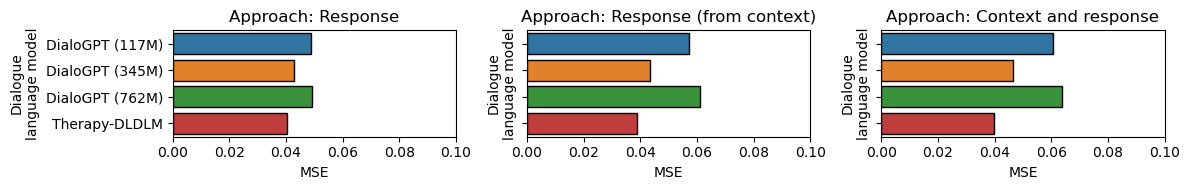

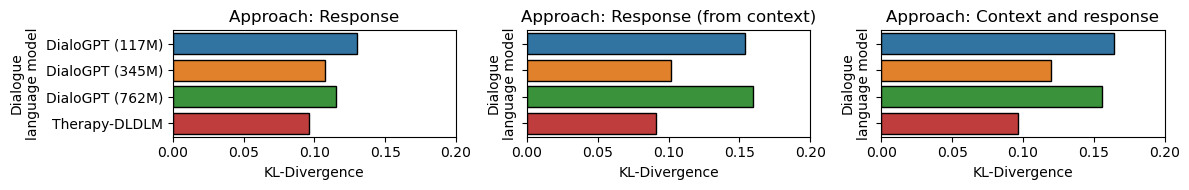

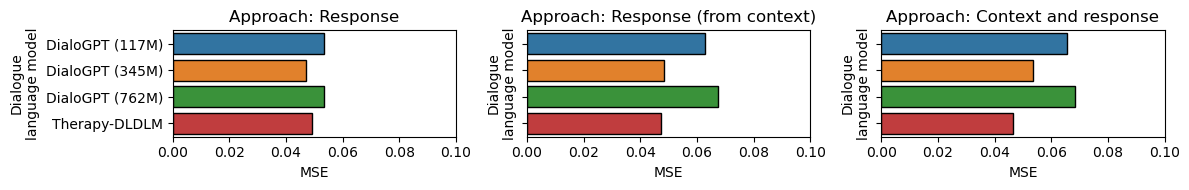

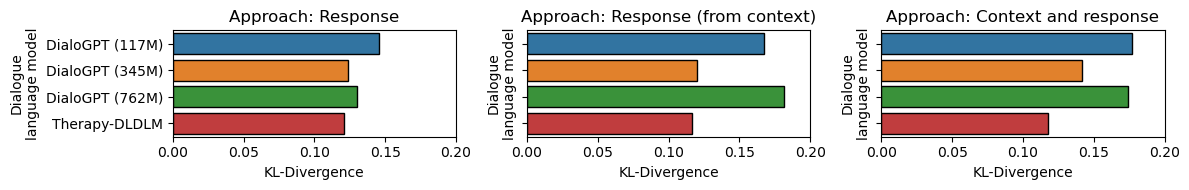

In [164]:
for split in tmp_df['Split'].unique():
    for metric in ['MSE', 'KL-Divergence']:
        fig, axes = plt.subplots(
            nrows=1,
            ncols=3,
            figsize=(12, 2),
            sharex='row',
            sharey=True
        )
        for i, approach in enumerate(['Response', 'Response (from context)', 'Context and response']):
            order = ['DialoGPT (117M)', 'DialoGPT (345M)', 'DialoGPT (762M)', 'Therapy-DLDLM']
            sns.barplot(
                data=tmp_df[(tmp_df['Split'] == split) & (tmp_df['Approach'] == approach)],
                x=metric, y='Dialogue\nlanguage model', order=order, ax=axes[i], linewidth=1., edgecolor='0', orient='h', errorbar=None
            )
            axes[i].set_title(f'Approach: {approach}')
            # axes[i].set_xscale('log')
            axes[i].set_xlim([0, 0.1] if metric == 'MSE' else [0, 0.2])
            axes[i].set_xlabel(metric)

        plt.tight_layout()
        plt.show()
        
        fig.savefig(
            os.path.join(
                OUTPUT_PATH,
                f'dgst_results_{split.lower()}_{metric.replace("(", "").replace(")", "").replace(" ", "_").replace("-", "_")}.pdf'
            ),
            bbox_inches='tight'
        )

In [99]:
tmp_df_final = tmp_df[(tmp_df['Dialogue language model'] == 'Therapy-DLDLM') & (tmp_df['Approach'] == 'Response (from context)')]
tmp_df_final['Frobenius norm (embeddings)'] = tmp_df_final['Frobenius norm (embeddings)'].apply(lambda x: x.item())
tmp_df_final['Frobenius norm (combination weights)'] = tmp_df_final['Frobenius norm (combination weights)'].apply(lambda x: x.item())

/tmp/ipykernel_196576/4195010380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df_final['Frobenius norm (embeddings)'] = tmp_df_final['Frobenius norm (embeddings)'].apply(lambda x: x.item())
/tmp/ipykernel_196576/4195010380.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df_final['Frobenius norm (combination weights)'] = tmp_df_final['Frobenius norm (combination weights)'].apply(lambda x: x.item())


In [100]:
tmp_df_final.groupby('Split', sort=False).mean()

/tmp/ipykernel_196576/3595912605.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df_final.groupby('Split', sort=False).mean()


,Params [M],MSE,KL-Divergence,Frobenius norm (embeddings),Frobenius norm (combination weights)
Split,,,,,
Test,762.0,0.038883,0.091256,197.516742,197.700090
Validation,762.0,0.047453,0.116191,202.349011,200.963408


In [101]:
tmp_df_final.groupby('Split', sort=False).std()

/tmp/ipykernel_196576/4108906290.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df_final.groupby('Split', sort=False).std()


,Params [M],MSE,KL-Divergence,Frobenius norm (embeddings),Frobenius norm (combination weights)
Split,,,,,
Test,0.0,0.025173,0.064261,65.372400,63.589642
Validation,0.0,0.041560,0.119078,70.888487,70.808800


In [123]:
import librosa
import numpy as np

In [112]:
path = tmp_df_final[tmp_df_final['Split'] == 'Test'].sample(1)['Audio file path'].values[0]

In [114]:
path

'IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M036.wav'

In [119]:
audio, sr = librosa.load(os.path.join(RAW_DATA_PATH, path), sr=None)
sr

16000

In [121]:
duration = librosa.get_duration(y=audio, sr=sr)
duration

3.27

In [ ]:
time = np.linspace(0, duration, audio.shape[0])

In [115]:
pred_data = load_data(os.path.join(DATA_PATH, f'predictions_resp_from_ctx_Therapy-DLDLM.pbz2'))

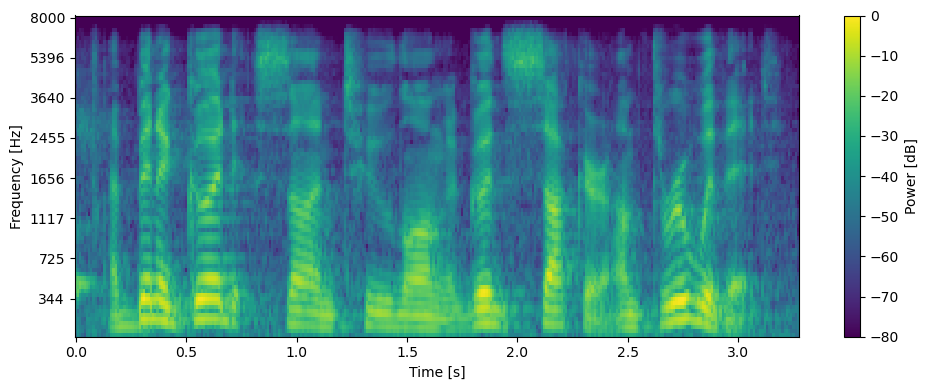

In [153]:
original_mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=512, win_length=400, hop_length=160, n_mels=80)

lin_freq = librosa.mel_frequencies(n_mels=80, fmax=8000)
mel_comp = np.arange(original_mel.shape[0]) + 1
mespec_time = np.linspace(0, duration, original_mel.shape[1])

fig = plt.figure(figsize=(10,4))
plt.pcolormesh(mespec_time, mel_comp, librosa.power_to_db(original_mel, ref=np.max))
plt.colorbar(label='Power [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.yticks(ticks=mel_comp[9::10], labels=[f'{freq:.0f}' for freq in lin_freq[9::10]])
plt.tight_layout()
plt.show()

In [154]:
fig.savefig(os.path.join(OUTPUT_PATH, f'melspec_original.pdf'), bbox_inches='tight')

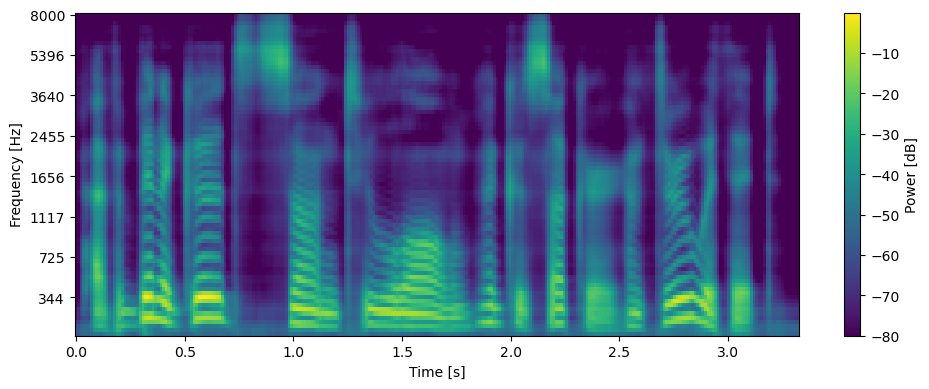

In [155]:
tgt_mel = tgt_data[path][-1].cpu().numpy()[0]

duration_mellotron = (mellotron_hparams['hop_length'] * tgt_mel.shape[-1] + mellotron_hparams['win_length']) / mellotron_hparams['sampling_rate']

lin_freq = librosa.mel_frequencies(n_mels=80, fmax=8000)
mel_comp = np.arange(tgt_mel.shape[0]) + 1
mespec_time = np.linspace(0, duration_mellotron, tgt_mel.shape[1])

fig = plt.figure(figsize=(10,4))
plt.pcolormesh(mespec_time, mel_comp, librosa.power_to_db(10 ** tgt_mel, ref=np.max))
plt.colorbar(label='Power [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.yticks(ticks=mel_comp[9::10], labels=[f'{freq:.0f}' for freq in lin_freq[9::10]])
plt.tight_layout()
plt.show()

In [156]:
fig.savefig(os.path.join(OUTPUT_PATH, f'melspec_tgt.pdf'), bbox_inches='tight')

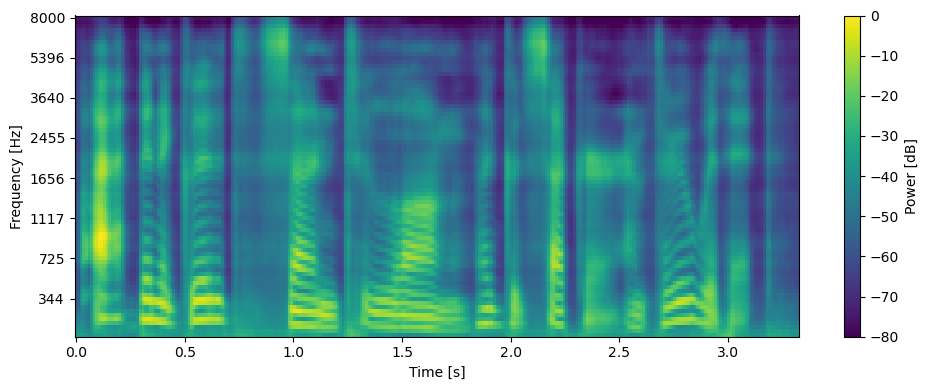

In [157]:
pred_mel_e = pred_data[path][-3].cpu().numpy()[0]

duration_mellotron = (mellotron_hparams['hop_length'] * pred_mel_e.shape[-1] + mellotron_hparams['win_length']) / mellotron_hparams['sampling_rate']

lin_freq = librosa.mel_frequencies(n_mels=80, fmax=8000)
mel_comp = np.arange(pred_mel_e.shape[0]) + 1
mespec_time = np.linspace(0, duration_mellotron, pred_mel_e.shape[1])

fig = plt.figure(figsize=(10,4))
plt.pcolormesh(mespec_time, mel_comp, librosa.power_to_db(10 ** pred_mel_e, ref=np.max))#librosa.power_to_db(tgt_mel, ref=np.max))
plt.colorbar(label='Power [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.yticks(ticks=mel_comp[9::10], labels=[f'{freq:.0f}' for freq in lin_freq[9::10]])
plt.tight_layout()
plt.show()

In [158]:
fig.savefig(os.path.join(OUTPUT_PATH, f'melspec_reconstruction_embeddings.pdf'), bbox_inches='tight')

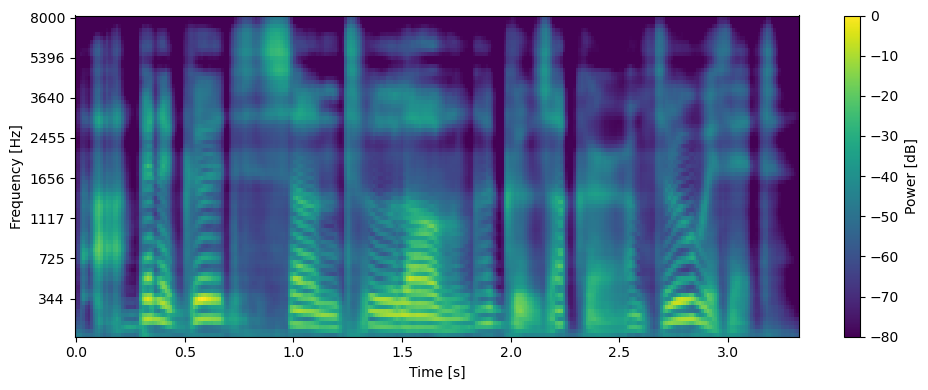

In [159]:
pred_mel_w = pred_data[path][-2].cpu().numpy()[0]

duration_mellotron = (mellotron_hparams['hop_length'] * pred_mel_w.shape[-1] + mellotron_hparams['win_length']) / mellotron_hparams['sampling_rate']

lin_freq = librosa.mel_frequencies(n_mels=80, fmax=8000)
mel_comp = np.arange(pred_mel_w.shape[0]) + 1
mespec_time = np.linspace(0, duration_mellotron, pred_mel_w.shape[1])

fig = plt.figure(figsize=(10,4))
plt.pcolormesh(mespec_time, mel_comp, librosa.power_to_db(10 ** pred_mel_w, ref=np.max))
plt.colorbar(label='Power [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.yticks(ticks=mel_comp[9::10], labels=[f'{freq:.0f}' for freq in lin_freq[9::10]])
plt.tight_layout()
plt.show()

In [160]:
fig.savefig(os.path.join(OUTPUT_PATH, f'melspec_reconstruction_weights.pdf'), bbox_inches='tight')